# Init

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Torch imports
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader

In [3]:
# Initialize torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Generate Dataset

In [5]:
# Generate data features - X
num_points = 100
np.random.seed(10)
X_class0 = 2 * np.random.rand(num_points // 2, 2)
X_class1 = 2 * np.random.rand(num_points // 2, 2) + np.array([2, 2])
X = np.vstack((X_class0, X_class1))

In [6]:
# Generate labels - y
y_class0 = np.zeros((num_points // 2, 1))
y_class1 = np.ones((num_points // 2, 1))
y = np.vstack((y_class0, y_class1))

In [7]:
# Add more noise to the target values
noise_factor = 0.6
X += noise_factor * np.random.randn(num_points, 1)

In [8]:
# Shuffle the data
shuffle_indices = np.random.permutation(num_points)
X = X[shuffle_indices]
y = y[shuffle_indices]

In [9]:
# Print data shapes
print(X.shape)
print(y.shape)

(100, 2)
(100, 1)


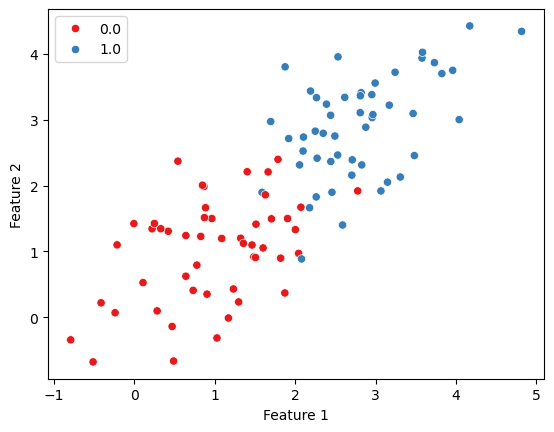

In [61]:
# Plot the generated data
sns.color_palette("tab10")
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y.flatten(), palette='Set1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [11]:
# Split data in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train - X:{X_train.shape}, y:{y_train.shape}')
print(f'Test  - X:{X_test.shape}, y:{y_test.shape}')

Train - X:(80, 2), y:(80, 1)
Test  - X:(20, 2), y:(20, 1)


In [12]:
# Data loader class
class Dataset(torch.utils.data.Dataset):

    # Constructor
    def __init__(self, data, targets):
        self.data = data.astype(np.float32)
        self.targets = targets.astype(np.float32)

    # Get item
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    # Length
    def __len__(self):
        return len(self.data)

In [13]:
# Create dataloaders
train_dataloader = DataLoader(Dataset(X_train, y_train), batch_size=20)
test_dataloader = DataLoader(Dataset(X_test, y_test), batch_size=20)

# Model

In [14]:
# Model class
class LogisticRegressionModel(nn.Module):

    # Constructor
    def __init__(self, input_shape):
        assert len(input_shape) == 2
        self.data_dims = input_shape[1]
        super().__init__()
        self.w = nn.Parameter(torch.ones((self.data_dims, 1)), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    # Forward pass
    def forward(self, input):
        assert len(input.shape) == 2
        assert input.shape[1] == self.data_dims
        z = torch.mm(input, self.w) + self.b
        output = torch.sigmoid(z)
        return output

In [53]:
# Train function to run every epoch
def train_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    size_d = len(str(size))
    num_batches = len(dataloader)
    total_loss = 0

    # Set model training mode
    model.train()

    # Loop batches
    for batch, (X, y) in enumerate(dataloader):

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Calculate outputs
        outputs = model(X)

        # Calculate losses
        loss = (torch.tensordot(y, -torch.log(outputs)) + torch.tensordot(1-y, -torch.log(1-outputs))) / len(X)
        loss.backward()
        total_loss += loss.item()

        # Optimize
        optimizer.step()
        optimizer.zero_grad()

        # Print batch log
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>{size_d}d}/{size:>{size_d}d}]")

    # Return total loss
    return total_loss/num_batches

In [54]:
# Test function to run every epoch
def test_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Set model evaluation mode
    model.eval()

    # Calulate loss
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = (torch.tensordot(y, -torch.log(outputs)) + torch.tensordot(1-y, -torch.log(1-outputs))) / len(X)
            test_loss += loss.item()
    
    # Print loss
    print(f"\nTest Error: \nAvg batch loss: {test_loss/num_batches:>8f} \n")
    
    # Return average loss
    return test_loss/num_batches

# Training

#### Create model and optimizer

In [55]:
# Hyperparameters
learning_rate = 0.1
epochs = 100

In [56]:
# Create model
input_shape = next(iter(train_dataloader))[0].shape
model = LogisticRegressionModel(input_shape)
model.to(device)

LogisticRegressionModel()

In [57]:
# Optimizer
optimizer = SGD(model.parameters(), lr=learning_rate)

#### Train model

In [58]:
# Run epochs
for epoch in range(epochs):

    # Log epoch details
    print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")

    # Train model
    train_loss = train_model(train_dataloader, model, optimizer)

    # Test model
    test_loss = test_model(test_dataloader, model, optimizer)

Epoch 1/100
-------------------------------
loss: 1.157220  [20/80]
loss: 0.992001  [40/80]
loss: 1.141503  [60/80]
loss: 0.828512  [80/80]

Test Error: 
Avg batch loss: 0.898393 

Epoch 2/100
-------------------------------
loss: 0.933360  [20/80]
loss: 0.785891  [40/80]
loss: 0.900808  [60/80]
loss: 0.663979  [80/80]

Test Error: 
Avg batch loss: 0.728743 

Epoch 3/100
-------------------------------
loss: 0.755391  [20/80]
loss: 0.624712  [40/80]
loss: 0.720504  [60/80]
loss: 0.554786  [80/80]

Test Error: 
Avg batch loss: 0.611304 

Epoch 4/100
-------------------------------
loss: 0.636732  [20/80]
loss: 0.522269  [40/80]
loss: 0.611639  [60/80]
loss: 0.502270  [80/80]

Test Error: 
Avg batch loss: 0.544412 

Epoch 5/100
-------------------------------
loss: 0.573834  [20/80]
loss: 0.473249  [40/80]
loss: 0.559843  [60/80]
loss: 0.485102  [80/80]

Test Error: 
Avg batch loss: 0.510669 

Epoch 6/100
-------------------------------
loss: 0.545332  [20/80]
loss: 0.454085  [40/80]
los

#### Analyze model

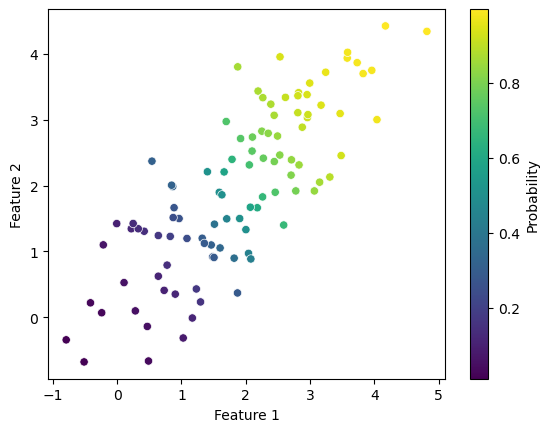

In [59]:
# Get model output and plot pobabilities
model_input = torch.from_numpy(X.astype(np.float32)).to(device)
model_output = model(model_input).detach().cpu().numpy().flatten()
fig, axes = plt.subplots()
scatter = sns.scatterplot(x=X[:,0], y=X[:,1], hue=model_output.flatten(), palette='viridis', legend=False)
scalar_mappable = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(model_output.min(), model_output.max()))
cbar = scatter.figure.colorbar(scalar_mappable, ax=axes)
cbar.set_label('Probability')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

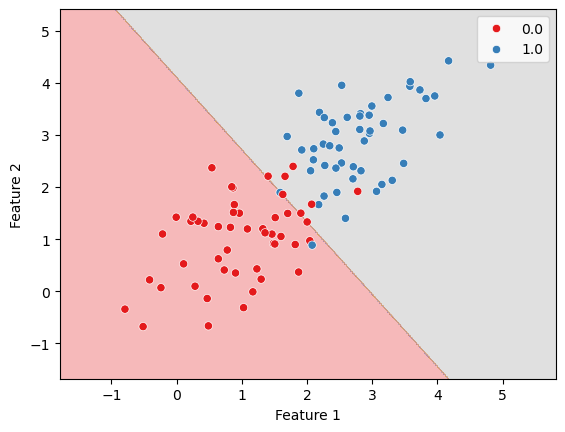

In [60]:
# Plot the actal labels with decision boundary
min_1, max_1 = np.min(X[:,0]) - 1, np.max(X[:,0]) + 1
min_2, max_2 = np.min(X[:,1]) - 1, np.max(X[:,1]) + 1
xx, yy = np.meshgrid(np.arange(min_1, max_1, 0.01), np.arange(min_2, max_2, 0.01))
Z = (model(torch.from_numpy((np.c_[xx.ravel(), yy.ravel()]).astype(np.float32)).to(device))).detach().cpu().numpy()
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, np.round(Z), cmap=sns.color_palette('Set1', as_cmap=True), alpha=0.3)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y.flatten(), palette='Set1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()